In [3]:
!git clone https://github.com/facebookresearch/dinov3.git /kaggle/working/dinov3

Cloning into '/kaggle/working/dinov3'...
remote: Enumerating objects: 276, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 276 (delta 29), reused 11 (delta 11), pack-reused 222 (from 2)
Receiving objects: 100% (276/276), 9.80 MiB | 25.80 MiB/s, done.
Resolving deltas: 100% (60/60), done.


In [74]:
from transformers.image_utils import load_image
import json
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

In [16]:
with open('/kaggle/input/id2label/id2label.json','r') as f:
    id2label = json.load(f)

In [21]:
id2label = {int(k): v for k, v in id2label.items()}

In [9]:
transforms = A.Compose([
    A.Resize(224, 224), 
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

In [10]:
REPO_DIR = '/kaggle/working/dinov3'   
CKPT_PATH = '/kaggle/input/dinov3/pytorch/default/1/dinov3_vitb16_pretrain_lvd1689m-73cec8be.pth'
feat_extract = torch.hub.load(REPO_DIR, 'dinov3_vitb16', source='local', weights=CKPT_PATH)

Downloading: "file:///kaggle/input/dinov3/pytorch/default/1/dinov3_vitb16_pretrain_lvd1689m-73cec8be.pth" to /root/.cache/torch/hub/checkpoints/dinov3_vitb16_pretrain_lvd1689m-73cec8be.pth
100%|██████████| 327M/327M [00:03<00:00, 95.9MB/s] 


In [55]:
class DinoClassifier(nn.Module):
    def __init__(self, feat_extractor, cls_len):
        super().__init__()
        self.feat_extractor = feat_extractor
        for param in self.feat_extractor.parameters():
            param.requires_grad = False
        self.cls_head = nn.Sequential(
            nn.Linear(self.feat_extractor.embed_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, cls_len)
        )

    def forward(self, x):
        out = self.feat_extractor(x)  
        logits = self.cls_head(out)
        return logits

In [56]:
state_dict = torch.load("/kaggle/input/trained_classifier/pytorch/default/1/best_classifier.pth", map_location="cpu")

model = DinoClassifier(feat_extract, len(id2label))

current_keys = set(model.state_dict().keys())
filtered = {k: v for k, v in state_dict.items() if k in current_keys}

missing, unexpected = model.load_state_dict(filtered, strict=False)
print("Missing keys:", missing)
print("Unexpected keys (ignored):", unexpected)

Missing keys: []
Unexpected keys (ignored): []


In [85]:
model.eval()

DinoClassifier(
  (feat_extractor): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (rope_embed): RopePositionEmbedding()
    (blocks): ModuleList(
      (0-11): 12 x SelfAttentionBlock(
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): SelfAttention(
          (qkv): LinearKMaskedBias(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.

In [161]:
CONFIDENCE_THRESHOLD = 0.45

Text(0.5, 1.0, 'Prediction: plant_Aloevera')

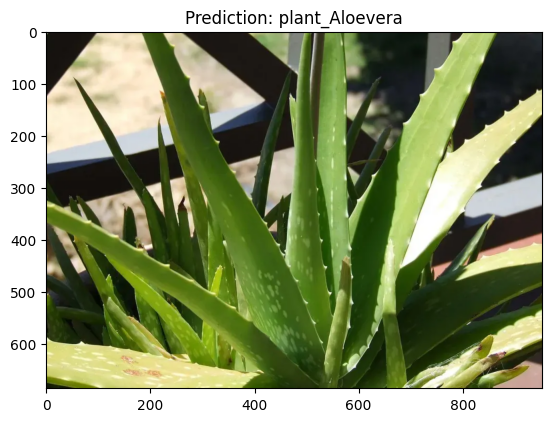

In [162]:
img = load_image('https://www.kew.org/sites/default/files/styles/plant_image_953w/public/2020-04/Aloe_Vera.jpg.webp?itok=HUuv13X2')
timg = transforms(image=np.array(img))['image'].unsqueeze(0)
with torch.no_grad():
    out = model(timg)
probs = F.softmax(out, dim=1)
max_prob = probs.max().item()
pred_class = id2label[probs.argmax().item()]
title = f'Prediction: {pred_class}'
if max_prob < CONFIDENCE_THRESHOLD:
    title += ' (Probably Wrong)'
plt.figure()
plt.imshow(img)
plt.title(title)

Text(0.5, 1.0, 'Prediction: leaf_Aloevera')

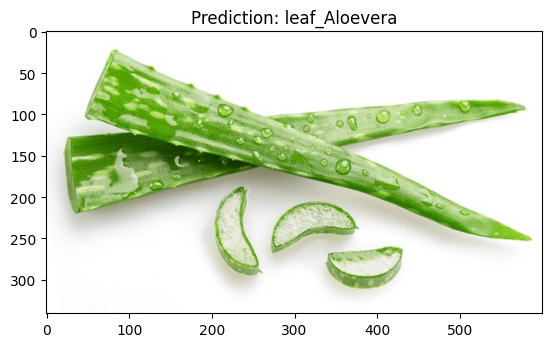

In [163]:
img = load_image('https://www.shutterstock.com/image-photo/fresh-cuts-aloe-vera-leaf-600nw-2589889811.jpg')
timg = transforms(image=np.array(img))['image'].unsqueeze(0)
with torch.no_grad():
    out = model(timg)
probs = F.softmax(out, dim=1)
max_prob = probs.max().item()
pred_class = id2label[probs.argmax().item()]
title = f'Prediction: {pred_class}'
if max_prob < CONFIDENCE_THRESHOLD:
    title += ' (Probably Wrong)'
plt.figure()
plt.imshow(img)
plt.title(title)

Text(0.5, 1.0, 'Prediction: plant_Amruta_Balli')

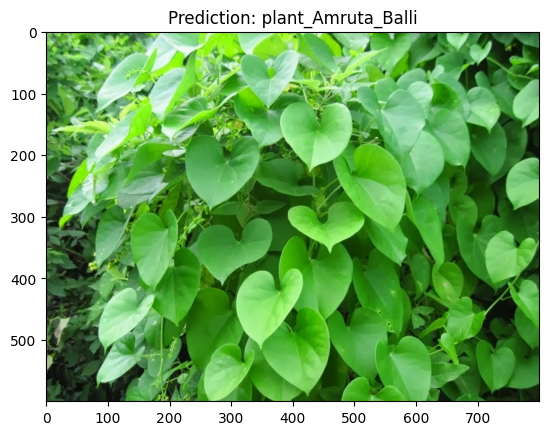

In [164]:
img = load_image('https://drvaidji.com/cdn/shop/articles/organic-giloy-leaves.jpg?v=1698470573')
timg = transforms(image=np.array(img))['image'].unsqueeze(0)
with torch.no_grad():
    out = model(timg)
probs = F.softmax(out, dim=1)
max_prob = probs.max().item()
pred_class = id2label[probs.argmax().item()]
title = f'Prediction: {pred_class}'
if max_prob < CONFIDENCE_THRESHOLD:
    title += ' (Probably Wrong)'
plt.figure()
plt.imshow(img)
plt.title(title)

Text(0.5, 1.0, 'Prediction: plant_Amla')

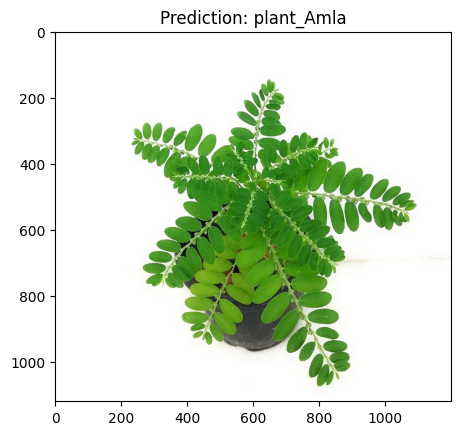

In [165]:
img = load_image('https://gachwala.in/wp-content/uploads/2023/05/rsw_1200h_1200.webp')
timg = transforms(image=np.array(img))['image'].unsqueeze(0)
with torch.no_grad():
    out = model(timg)
probs = F.softmax(out, dim=1)
max_prob = probs.max().item()
pred_class = id2label[probs.argmax().item()]
title = f'Prediction: {pred_class}'
if max_prob < CONFIDENCE_THRESHOLD:
    title += ' (Probably Wrong)'
plt.figure()
plt.imshow(img)
plt.title(title)

Text(0.5, 1.0, 'Prediction: plant_Betel')

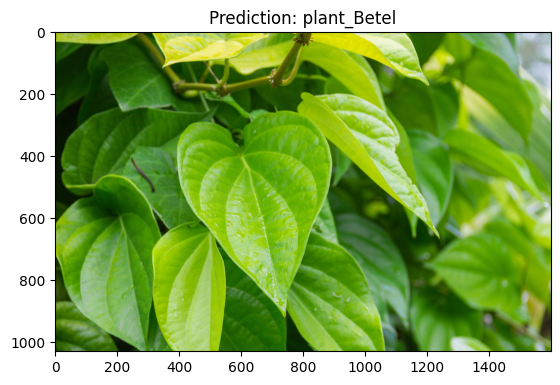

In [166]:
img = load_image('https://cdn.britannica.com/02/218302-050-B19E71BA/betel-pepper-or-pan-plant-piper-betle-leaves.jpg')
timg = transforms(image=np.array(img))['image'].unsqueeze(0)
with torch.no_grad():
    out = model(timg)
probs = F.softmax(out, dim=1)
max_prob = probs.max().item()
pred_class = id2label[probs.argmax().item()]
title = f'Prediction: {pred_class}'
if max_prob < CONFIDENCE_THRESHOLD:
    title += ' (Probably Wrong)'
plt.figure()
plt.imshow(img)
plt.title(title)

Text(0.5, 1.0, 'Prediction: leaf_Betel')

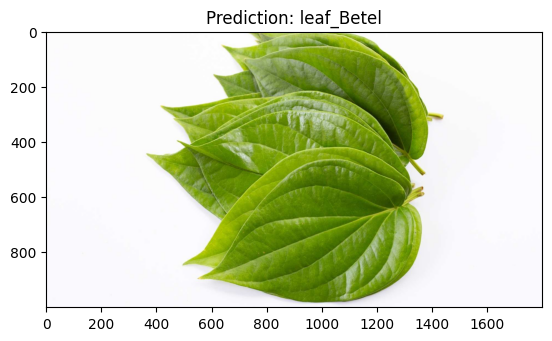

In [167]:
img = load_image('https://cdn.shopify.com/s/files/1/1780/8157/files/other_possible_benefits_of_betel_leaf.jpg?v=1651670450')
timg = transforms(image=np.array(img))['image'].unsqueeze(0)
with torch.no_grad():
    out = model(timg)
probs = F.softmax(out, dim=1)
max_prob = probs.max().item()
pred_class = id2label[probs.argmax().item()]
title = f'Prediction: {pred_class}'
if max_prob < CONFIDENCE_THRESHOLD:
    title += ' (Probably Wrong)'
plt.figure()
plt.imshow(img)
plt.title(title)

Text(0.5, 1.0, 'Prediction: plant_Raktachandini')

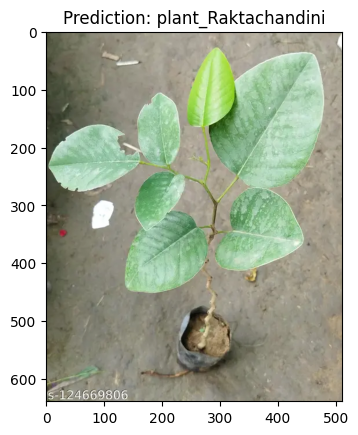

In [168]:
img = load_image('https://images.meesho.com/images/products/124669806/y9ujd_512.webp?width=512')
timg = transforms(image=np.array(img))['image'].unsqueeze(0)
with torch.no_grad():
    out = model(timg)
probs = F.softmax(out, dim=1)
max_prob = probs.max().item()
pred_class = id2label[probs.argmax().item()]
title = f'Prediction: {pred_class}'
if max_prob < CONFIDENCE_THRESHOLD:
    title += ' (Probably Wrong)'
plt.figure()
plt.imshow(img)
plt.title(title)

Text(0.5, 1.0, 'Prediction: leaf_Bhrami')

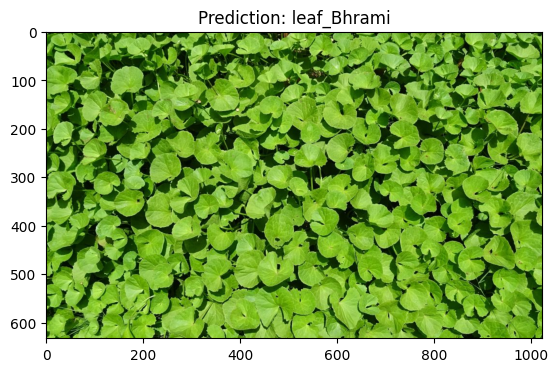

In [169]:
img = load_image('https://novobliss.in/wp-content/uploads/2022/01/Brahmi-.jpg')
timg = transforms(image=np.array(img))['image'].unsqueeze(0)
with torch.no_grad():
    out = model(timg)
probs = F.softmax(out, dim=1)
max_prob = probs.max().item()
pred_class = id2label[probs.argmax().item()]
title = f'Prediction: {pred_class}'
if max_prob < CONFIDENCE_THRESHOLD:
    title += ' (Probably Wrong)'
plt.figure()
plt.imshow(img)
plt.title(title)

Text(0.5, 1.0, 'Prediction: plant_Tulasi')

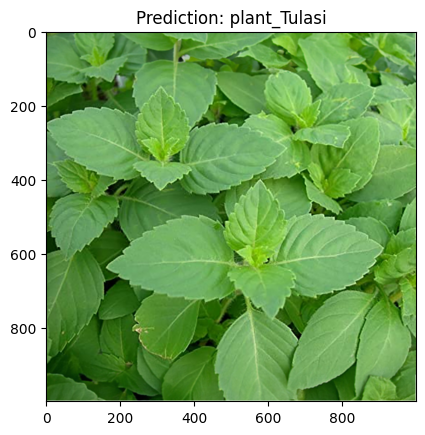

In [170]:
img = load_image('https://gachwala.in/wp-content/uploads/2022/06/tulsi-varieties.jpg')
timg = transforms(image=np.array(img))['image'].unsqueeze(0)
with torch.no_grad():
    out = model(timg)
probs = F.softmax(out, dim=1)
max_prob = probs.max().item()
pred_class = id2label[probs.argmax().item()]
title = f'Prediction: {pred_class}'
if max_prob < CONFIDENCE_THRESHOLD:
    title += ' (Probably Wrong)'
plt.figure()
plt.imshow(img)
plt.title(title)

Text(0.5, 1.0, 'Prediction: leaf_Neem')

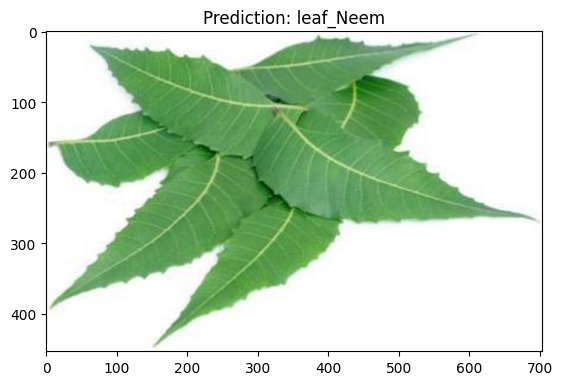

In [171]:
img = load_image('https://rukminim2.flixcart.com/image/704/844/ksru0sw0/vegetable/h/j/f/100-neem-leaves-unbranded-no-whole-original-imag69zefzux5ce2.jpeg?q=90&crop=false')
timg = transforms(image=np.array(img))['image'].unsqueeze(0)
with torch.no_grad():
    out = model(timg)
probs = F.softmax(out, dim=1)
max_prob = probs.max().item()
pred_class = id2label[probs.argmax().item()]
title = f'Prediction: {pred_class}'
if max_prob < CONFIDENCE_THRESHOLD:
    title += ' (Probably Wrong)'
plt.figure()
plt.imshow(img)
plt.title(title)

Text(0.5, 1.0, 'Prediction: leaf_Mint')

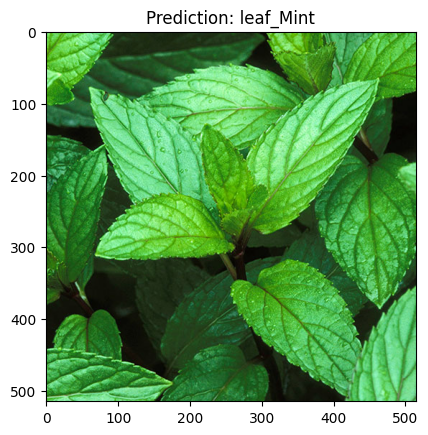

In [172]:
img = load_image('https://files.nccih.nih.gov/peppermint-steven-foster-square.jpg')
timg = transforms(image=np.array(img))['image'].unsqueeze(0)
with torch.no_grad():
    out = model(timg)
probs = F.softmax(out, dim=1)
max_prob = probs.max().item()
pred_class = id2label[probs.argmax().item()]
title = f'Prediction: {pred_class}'
if max_prob < CONFIDENCE_THRESHOLD:
    title += ' (Probably Wrong)'
plt.figure()
plt.imshow(img)
plt.title(title)

Text(0.5, 1.0, 'Prediction: leaf_Turmeric')

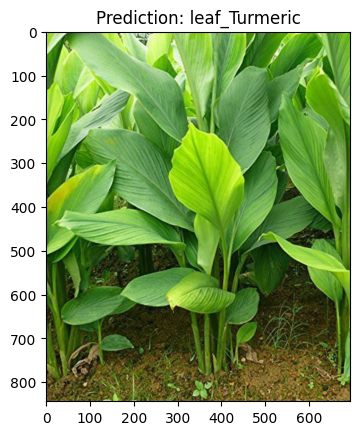

In [173]:
img = load_image('https://rukminim2.flixcart.com/image/704/844/ksxjs7k0/plant-sapling/6/x/v/no-perennial-no-pnmp182-1-stamen-original-imag6eydkcyebyrc.jpeg?q=90&crop=false')
timg = transforms(image=np.array(img))['image'].unsqueeze(0)
with torch.no_grad():
    out = model(timg)
probs = F.softmax(out, dim=1)
max_prob = probs.max().item()
pred_class = id2label[probs.argmax().item()]
title = f'Prediction: {pred_class}'
if max_prob < CONFIDENCE_THRESHOLD:
    title += ' (Probably Wrong)'
plt.figure()
plt.imshow(img)
plt.title(title)

Text(0.5, 1.0, 'Prediction: plant_Ashwagandha')

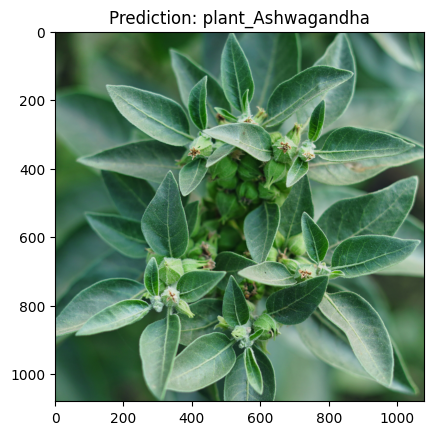

In [174]:
img = load_image('https://www.ahpa.org//Files/Herbs-in-History/43_Ashwagandha/ashwagandha_thumbnail.png')
timg = transforms(image=np.array(img))['image'].unsqueeze(0)
with torch.no_grad():
    out = model(timg)
probs = F.softmax(out, dim=1)
max_prob = probs.max().item()
pred_class = id2label[probs.argmax().item()]
title = f'Prediction: {pred_class}'
if max_prob < CONFIDENCE_THRESHOLD:
    title += ' (Probably Wrong)'
plt.figure()
plt.imshow(img)
plt.title(title)

Text(0.5, 1.0, 'Prediction: plant_Bamboo (Probably Wrong)')

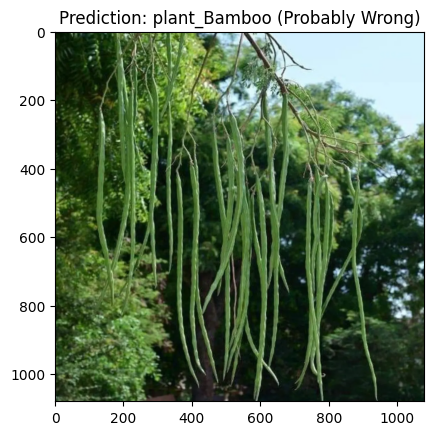

In [175]:
### Wrong Prediction

img = load_image('https://nurserynisarga.in/wp-content/uploads/2023/02/d5.webp')
timg = transforms(image=np.array(img))['image'].unsqueeze(0)
with torch.no_grad():
    out = model(timg)
probs = F.softmax(out, dim=1)
max_prob = probs.max().item()
pred_class = id2label[probs.argmax().item()]
title = f'Prediction: {pred_class}'
if max_prob < CONFIDENCE_THRESHOLD:
    title += ' (Probably Wrong)'
plt.figure()
plt.imshow(img)
plt.title(title)

Text(0.5, 1.0, 'Prediction: plant_Amla (Probably Wrong)')

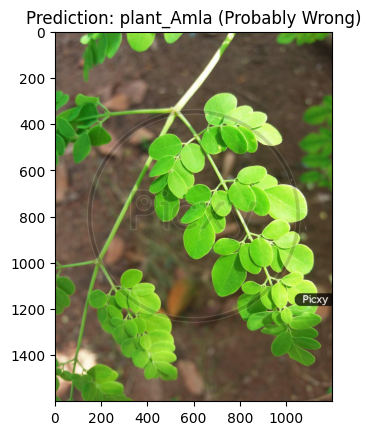

In [176]:
### again wrong, "Drumstick" is not doing well

img = load_image('https://images.picxy.com/cache/2020/5/6/6a7657fc8a21afd990c68450fdf533f6.jpg')
timg = transforms(image=np.array(img))['image'].unsqueeze(0)
with torch.no_grad():
    out = model(timg)
probs = F.softmax(out, dim=1)
max_prob = probs.max().item()
pred_class = id2label[probs.argmax().item()]
title = f'Prediction: {pred_class}'
if max_prob < CONFIDENCE_THRESHOLD:
    title += ' (Probably Wrong)'
plt.figure()
plt.imshow(img)
plt.title(title)

Text(0.5, 1.0, 'Prediction: leaf_Guava')

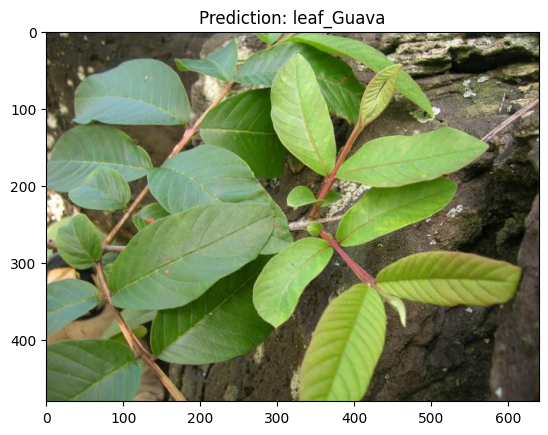

In [177]:
img = load_image('https://www.feedipedia.org/sites/default/files/images/psidium_guajava_leaves_starr.jpg')
timg = transforms(image=np.array(img))['image'].unsqueeze(0)
with torch.no_grad():
    out = model(timg)
probs = F.softmax(out, dim=1)
max_prob = probs.max().item()
pred_class = id2label[probs.argmax().item()]
title = f'Prediction: {pred_class}'
if max_prob < CONFIDENCE_THRESHOLD:
    title += ' (Probably Wrong)'
plt.figure()
plt.imshow(img)
plt.title(title)